# Vaximap dataset analysis: time saving estimates 

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from pyproj import Transformer
import matplotlib.pyplot as plt
from scipy import spatial, optimize
from matplotlib.cm import get_cmap
import matplotlib.dates as mdates
from collections import Counter
import sys
sys.path.append('..')
from load_dataset import dataset as raw_dataset
import seaborn as sns 

Loading database /Users/thomaskirk/Code/vaximap_paper/analysis/../load_dataset/may_2022.h5


`UK_CENTER` is used to shift all relative latlong coords onto the approximate center of the UK. `DETOUR_INDEX` is selected from the literature as the midpoint of the quoted range of 1.2 to 1.6. `REPEAT_THRESHOLD` is set at 21 days, the minimum permissible time between identical requests. `MAX_PAIR_DIST` is set to 64 km, the maximum allowed distance between individual patients. Distances greater than this are assumed to be due to geocoding errors and will be zeroed. 

In [2]:
CMAP = np.array(get_cmap('tab10').colors)
UK_CENTER = (53, -1.2)
DETOUR_INDEX = 1.4
REPEAT_THRESHOLD = 21 # days 
MEAN_SPEED = 50 # kmh 
MAX_PAIR_DIST = 64e3 # km 

These values are taken from the linear regressions performed in the `survey/survey_analysis` notebook; both are in seconds per patient location

In [3]:
LOOKUP_COEFFICIENT = 36.4/60
ROUTING_COEFFICIENT = 4.8/60

This is what a single row of the raw dataset (including repeats) looks like 

In [4]:
print("Length of raw dataset = {:,}".format(len(raw_dataset)))
print("Number of patients in raw dataset = {:,}".format(raw_dataset.n_patients.sum()))
raw_dataset.tail(1)

Length of raw dataset = 13,016
Number of patients in raw dataset = 395,058


n_patients  n_clusters  \
6047          18           1   

                                                latlong  \
6047  [[0.0002589755588076059, -0.006635642713970657...   

                                               clusters region    postcodes  \
6047  [[9, 16, 12, 15, 17, 11, 2, 0, 7, 13, 8, 6, 3,...     UK  {'NN6': 18}   

         created     mode  
6047  2022-05-23  driving

## Repeat removal

Identifying and removing repeat requests below `REPEAT_THRESHOLD`. We also need to remove the testing dataset (ID 2058)

In [5]:
# Test to identify duplicates: need to convert latlong numpy to string beforehand to be able to drop
# We also perform a basic sort of latlong coords (on the x-dimension) to guard against cases where the 
# same set of addresses was uploaded in a new order 
def sort_latlong(arr): 
    inds = np.argsort(arr[:,0])
    return arr[inds,:]

raw_dataset["latlong_str"] = raw_dataset.latlong.apply(sort_latlong)
raw_dataset["latlong_str"] = raw_dataset.latlong.astype("str")
raw_dataset = raw_dataset.sort_values("latlong_str")

# extract number of duplicates from pandas duplicated inbuilt function
raw_dataset["is_duplicate"] = raw_dataset.duplicated(subset="latlong_str", keep="last")
print(f"Number of duplicates = {raw_dataset.is_duplicate.sum()} rows")
print(f"Number of distinct sets in dataset = {(~raw_dataset.is_duplicate).sum()} rows")

Number of duplicates = 3741 rows
Number of distinct sets in dataset = 9275 rows


<AxesSubplot:title={'center':'Frequency of duplicated set of lat/lons'}, xlabel='Number of duplications', ylabel='Count'>

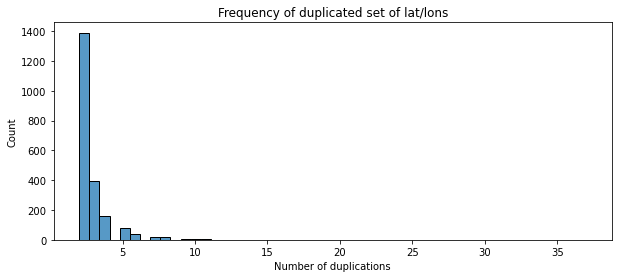

In [6]:
# plot histogram of frequency of duplicate set occurring (not showing cases without duplicates)
x = raw_dataset.groupby("latlong_str").count().sort_values("is_duplicate", ascending=False)
x = x.loc[x.is_duplicate > 1]

fig, ax = plt.subplots(figsize=(10,4))
ax.set_title("Frequency of duplicated set of lat/lons")
ax.set_xlabel("Number of duplications")
sns.histplot(x.is_duplicate, bins=50)

In [7]:
uniques = raw_dataset[~raw_dataset.latlong_str.duplicated(keep='last')][["latlong_str"]]
uid = uniques.reset_index().index
uniques["unique_id"] = uid 
uniques.head(10)

latlong_str  unique_id
3100  [[  0.52405293   3.92101897]\n [  0.55872712  ...          0
6042  [[  1.52743332  -2.14387918]\n [  1.5440158   ...          1
6096  [[  2.08087415  -3.12047635]\n [  2.07904345  ...          2
4207  [[ 0.00010027 -0.00950693]\n [-0.00746809 -0.0...          3
5863  [[ 0.00010147 -0.00756576]\n [ 0.00010147 -0.0...          4
1009  [[ 0.00010223 -0.03702307]\n [-0.00110703 -0.0...          5
5483  [[ 0.00010521  0.01476635]\n [ 0.00171501  0.0...          6
3873  [[ 0.00010808  0.00197951]\n [ 0.00021871 -0.0...          7
6721  [[ 0.00011177  0.0087476 ]\n [ 0.00711937 -0.0...          8
819   [[ 0.00011349  0.00660739]\n [-0.00165661 -0.0...          9

In [8]:
dataset_repeat = pd.merge(raw_dataset, uniques[["latlong_str","unique_id"]], 
        on="latlong_str", validate="m:1")
dataset_repeat = dataset_repeat.drop(['latlong_str', 'is_duplicate'], axis=1)
dataset_repeat["created"] = pd.to_datetime(dataset_repeat["created"])

# Sanity check - assert all latlongs equal for each uid
for ui in np.unique(dataset_repeat.unique_id): 
    subset = dataset_repeat[dataset_repeat.unique_id == ui].latlong.values 
    assert all([ (subset[0] == s).all() for s in subset ])
    
dataset_repeat.head(10)

n_patients  n_clusters                                            latlong  \
0          24           2  [[0.5240529250000066, 3.921018975], [0.5587271...   
1          24           2  [[0.5240529250000066, 3.921018975], [0.5587271...   
2          24           2  [[0.5240529250000066, 3.921018975], [0.5587271...   
3          24           2  [[1.5274333159128801, -2.1438791751861572], [1...   
4          24           2  [[1.5274333159128801, -2.1438791751861572], [1...   
5          24           2  [[1.5274333159128801, -2.1438791751861572], [1...   
6          24           2  [[1.5274333159128801, -2.1438791751861572], [1...   
7          10           1  [[2.08087414887207, -3.1204763505982402], [2.0...   
8          10           1  [[2.08087414887207, -3.1204763505982402], [2.0...   
9         172          15  [[0.0001002688740570079, -0.00950693391090196]...   

                                            clusters region  \
0  [[18, 6, 7, 5, 4, 9, 1, 8, 3, 2, 13, 12, 11, 1...     UK   
1  [[18, 6, 7, 5, 4, 9, 1, 8, 3, 2, 13, 12, 11, 1...     UK   
2  [[8, 1, 2, 3, 7, 5, 4, 6, 9, 18, 13, 12, 11, 1...     UK   
3  [[7, 8, 22, 1, 6, 14, 0, 3, 11, 13, 17, 4, 10,...     UK   
4  [[7, 8, 22, 1, 6, 14, 0, 3, 11, 13, 17, 4, 10,...     UK   
5  [[7, 8, 22, 1, 6, 14, 0, 3, 11, 13, 17, 4, 10,...     UK   
6  [[7, 8, 22, 1, 6, 14, 0, 3, 11, 13, 17, 4, 10,...     UK   
7                   [[5, 3, 7, 0, 1, 9, 2, 6, 8, 4]]     UK   
8                   [[5, 3, 7, 0, 1, 9, 2, 6, 8, 4]]     UK   
9  [[6, 18, 105, 34, 93, 35, 29, 7, 120, 121, 44,...     UK   

                                           postcodes    created     mode  \
0                                                 {} 2021-02-01  driving   
1                                                 {} 2021-02-01  driving   
2                                                 {} 2021-02-01  driving   
3                                                 {} 2021-02-12  driving   
4                                                 {} 2021-02-12  driving   
5                                                 {} 2021-02-12  driving   
6                                                 {} 2021-02-12  driving   
7                                                 {} 2021-02-12  driving   
8                                                 {} 2021-02-12  driving   
9  {'WN5': 134, 'WN3': 14, 'WN1': 17, 'WN2': 1, '... 2021-12-09  driving   

   unique_id  
0          0  
1          0  
2          0  
3          1  
4          1  
5          1  
6          1  
7          2  
8          2  
9          3

In [9]:
time_final = np.zeros(dataset_repeat.shape[0], int)
dataset_repeat = dataset_repeat.sort_values(['unique_id', 'created'])

for uid in range(dataset_repeat.unique_id.max()+1): 
    fltr = np.flatnonzero(dataset_repeat.unique_id == uid)
    if fltr.size < 2: 
        continue
    end = dataset_repeat.iloc[fltr[-1]].created
    for row in fltr[:-1]: 
        start = dataset_repeat.iloc[row].created
        t = (end - start).days 
        time_final[row] = t 

dataset_repeat["days_to_last"] = time_final
dataset_repeat["days_to_next"] = (dataset_repeat.days_to_last - dataset_repeat.days_to_last.shift(-1)).fillna(0).astype(int)
dataset_repeat["days_to_next"] = dataset_repeat["days_to_next"].clip(lower=0)
dataset_repeat.head(10)

n_patients  n_clusters                                            latlong  \
0          24           2  [[0.5240529250000066, 3.921018975], [0.5587271...   
1          24           2  [[0.5240529250000066, 3.921018975], [0.5587271...   
2          24           2  [[0.5240529250000066, 3.921018975], [0.5587271...   
3          24           2  [[1.5274333159128801, -2.1438791751861572], [1...   
4          24           2  [[1.5274333159128801, -2.1438791751861572], [1...   
5          24           2  [[1.5274333159128801, -2.1438791751861572], [1...   
6          24           2  [[1.5274333159128801, -2.1438791751861572], [1...   
7          10           1  [[2.08087414887207, -3.1204763505982402], [2.0...   
8          10           1  [[2.08087414887207, -3.1204763505982402], [2.0...   
9         172          15  [[0.0001002688740570079, -0.00950693391090196]...   

                                            clusters region  \
0  [[18, 6, 7, 5, 4, 9, 1, 8, 3, 2, 13, 12, 11, 1...     UK   
1  [[18, 6, 7, 5, 4, 9, 1, 8, 3, 2, 13, 12, 11, 1...     UK   
2  [[8, 1, 2, 3, 7, 5, 4, 6, 9, 18, 13, 12, 11, 1...     UK   
3  [[7, 8, 22, 1, 6, 14, 0, 3, 11, 13, 17, 4, 10,...     UK   
4  [[7, 8, 22, 1, 6, 14, 0, 3, 11, 13, 17, 4, 10,...     UK   
5  [[7, 8, 22, 1, 6, 14, 0, 3, 11, 13, 17, 4, 10,...     UK   
6  [[7, 8, 22, 1, 6, 14, 0, 3, 11, 13, 17, 4, 10,...     UK   
7                   [[5, 3, 7, 0, 1, 9, 2, 6, 8, 4]]     UK   
8                   [[5, 3, 7, 0, 1, 9, 2, 6, 8, 4]]     UK   
9  [[6, 18, 105, 34, 93, 35, 29, 7, 120, 121, 44,...     UK   

                                           postcodes    created     mode  \
0                                                 {} 2021-02-01  driving   
1                                                 {} 2021-02-01  driving   
2                                                 {} 2021-02-01  driving   
3                                                 {} 2021-02-12  driving   
4                                                 {} 2021-02-12  driving   
5                                                 {} 2021-02-12  driving   
6                                                 {} 2021-02-12  driving   
7                                                 {} 2021-02-12  driving   
8                                                 {} 2021-02-12  driving   
9  {'WN5': 134, 'WN3': 14, 'WN1': 17, 'WN2': 1, '... 2021-12-09  driving   

   unique_id  days_to_last  days_to_next  
0          0             0             0  
1          0             0             0  
2          0             0             0  
3          1             0             0  
4          1             0             0  
5          1             0             0  
6          1             0             0  
7          2             0             0  
8          2             0             0  
9          3             0             0

In [12]:
for uid in range(dataset_repeat.unique_id.max()+1): 
    fltr = np.flatnonzero(dataset_repeat.unique_id == uid)
    dates = sorted(dataset_repeat.iloc[fltr].created)

    if len(dates) > 10: 
        print(uid, [ (dates[-1] - d).days for d in dates[:-1] ])

135 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
289 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
4193 [45, 45, 45, 45, 45, 45, 45, 45, 5, 5, 5]
4591 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
4986 [17, 17, 17, 17, 17, 17, 13, 13, 13, 13, 13, 13, 12, 12, 12]
6660 [6, 6, 6, 6, 6, 6, 6, 6, 1, 0]
8171 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
8868 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
9109 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
9124 [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]


Can see here that vast majority of duplicates occur same day, only a minority occurring on further days

3057, 2964, 2963 are the test sets used during development (24 patients, driving, OX postcodes)

In [13]:
for idx in [3057, 2964, 2963]: 
    dataset_repeat = dataset_repeat[dataset_repeat.unique_id != idx]

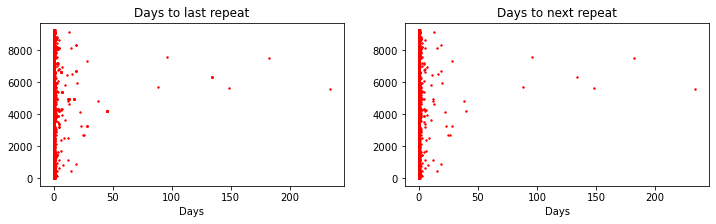

In [15]:
# for each record plot the time gaps - note y axis is record id (so ordering is meaningless)
fig, axes = plt.subplots(1,2, figsize=(12,3))

ax = axes[0]
ax.set_title("Days to last repeat")
ax.set_xlabel("Days")
ax.scatter(dataset_repeat.days_to_last, dataset_repeat.unique_id, 2, color="r")

ax = axes[1]
ax.set_title("Days to next repeat")
ax.set_xlabel("Days")
ax.scatter(dataset_repeat.days_to_next, dataset_repeat.unique_id, 2, color="r")

Note that the gap to the next ocurrence is the same as the gap to the final ocurrence in almost all cases - this is because almost all repeats come up twice. 

## Repeat analysis 
The irrelevant repeats have been removed; what can we say about the ones that remain?

In [19]:
valid_repeats = dataset_repeat[dataset_repeat.days_to_next >= REPEAT_THRESHOLD]
last_repeats = dataset_repeat[~dataset_repeat.unique_id.duplicated(keep='last')]
last_repeats = last_repeats[last_repeats.unique_id.isin(valid_repeats.unique_id)]
valid_repeats = pd.concat([valid_repeats, last_repeats])
valid_repeats = valid_repeats.sort_values('unique_id')
counts = valid_repeats.unique_id.value_counts().to_frame().rename({'unique_id': "rpt_count"}, axis=1)
valid_repeats = pd.merge(valid_repeats, counts, left_on='unique_id', right_index=True)
valid_repeats = valid_repeats.sort_values('rpt_count')
valid_repeats.head(10)

n_patients  n_clusters  \
3703            8           1   
10492           7           1   
10493           7           1   
10232          18           2   
10234          18           2   
8866            6           1   
8865            6           1   
7991            6           1   
7992            6           1   
7913           15           2   

                                                 latlong  \
3703   [[0.014923572540283203, -0.09073472023010254],...   
10492  [[-0.019066401890349027, 0.000491133757999973]...   
10493  [[-0.019066401890349027, 0.000491133757999973]...   
10232  [[-0.014597998725044192, -0.005178776052263023...   
10234  [[-0.014597998725044192, -0.005178776052263023...   
8866   [[-0.006197611490883048, -0.012261168410380677...   
8865   [[-0.006197611490883048, -0.012261168410380677...   
7991   [[-0.0036245981852189857, -0.00343434015909815...   
7992   [[-0.0036245981852189857, -0.00343434015909815...   
7913   [[-0.0034563700358063443, 0.007438467194636665...   

                                                clusters region  \
3703                          [[6, 3, 4, 0, 5, 2, 1, 7]]     UK   
10492                            [[2, 3, 0, 5, 6, 1, 4]]     UK   
10493                            [[2, 3, 0, 5, 6, 1, 4]]     UK   
10232  [[6, 7, 8, 9, 14, 12, 13, 1, 0, 4, 5], [3, 2, ...     UK   
10234  [[6, 7, 8, 9, 14, 12, 13, 1, 4, 0, 3, 5], [2, ...     UK   
8866                                [[2, 4, 1, 3, 0, 5]]     UK   
8865                                [[2, 4, 1, 3, 0, 5]]     UK   
7991                                [[2, 3, 0, 1, 4, 5]]     UK   
7992                                [[2, 3, 0, 1, 4, 5]]     UK   
7913   [[0, 4, 13, 11, 7, 14, 12, 1, 2, 3, 5, 6, 8], ...     UK   

                                      postcodes    created     mode  \
3703                                         {} 2021-03-25  driving   
10492                                        {} 2021-03-02  driving   
10493         {'SG17': 3, 'SG16': 2, 'MK45': 2} 2021-08-31  driving   
10232  {'PO1': 7, 'PO2': 5, 'PO3': 3, 'PO6': 3} 2021-12-16  driving   
10234  {'PO1': 7, 'PO2': 5, 'PO3': 3, 'PO6': 3} 2022-01-13  driving   
8866            {'CR0': 2, 'SE25': 2, 'CR7': 2} 2021-06-09  driving   
8865            {'CR0': 2, 'SE25': 2, 'CR7': 2} 2021-10-21  driving   
7991                                 {'HR2': 6} 2021-12-16  driving   
7992                                 {'HR2': 6} 2022-03-14  driving   
7913                               {'SE23': 15} 2022-05-05  driving   

       unique_id  days_to_last  days_to_next  rpt_count  
3703        2701            25            25          2  
10492       7560           182           182          2  
10493       7560             0             0          2  
10232       7365            28            28          2  
10234       7365             0             0          2  
8866        6352           134           134          2  
8865        6352             0             0          2  
7991        5728            88            88          2  
7992        5728             0             0          2  
7913        5673             0             0          2

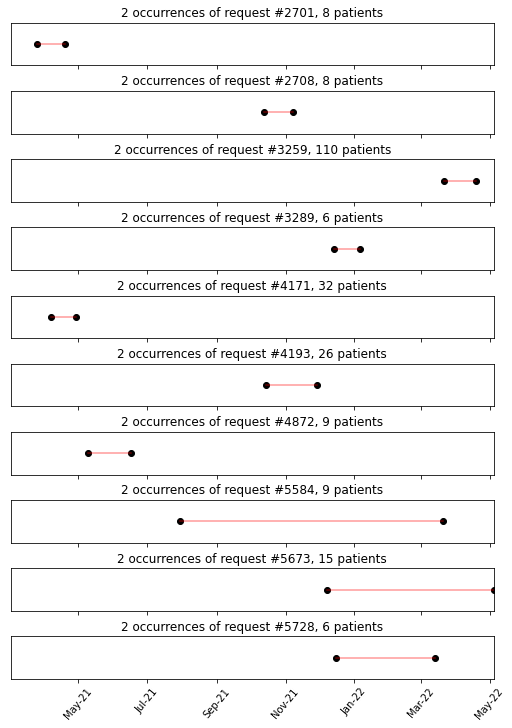

In [35]:
N = 10
fig, axes = plt.subplots(N, 1, figsize=(7,N), sharex=True, constrained_layout=True)
for uid,ax in zip(counts.index[:N], axes.flat):
    z1 = valid_repeats.loc[valid_repeats.unique_id == uid]
    x = pd.to_datetime(z1.created)
    ax.set_title("{} occurrences of request #{}, {} patients"
                .format(z1.shape[0], uid, z1.n_patients.iloc[0]))
    ax.plot(x, z1.unique_id, "r", alpha=0.4)
    ax.set_xlim(valid_repeats.created.min(), valid_repeats.created.max())
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticks(), rotation = 50)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
    ax.scatter(z1.created, z1.unique_id, color="black")
    ax.set_yticks([])


In [25]:
# Remove duplicate indices from raw dataset, keeping "last" assuming earlier duplicates were for testing
repeated = dataset_repeat.unique_id.duplicated(keep='last')
dataset_nonrepeat = dataset_repeat[~repeated]
print("Length of dataset without repeats = {:,}".format(len(dataset_nonrepeat)))
print("Number of repeats found = {:,}".format(len(repeated) - len(dataset_nonrepeat)))
print("Number of patints in dataset without repeats = {:,}".format(dataset_nonrepeat.n_patients.sum()))
print("Length of dataset with repeats = {:,}".format(len(dataset_repeat)))
print("Number of patients in dataset with repeats = {:,}".format(dataset_repeat.n_patients.sum()))

Length of dataset without repeats = 9,272
Number of repeats found = 3,666
Number of patients in dataset without repeats = 256,903
Length of dataset with repeats = 12,938
Number of patients in dataset with repeats = 393,186


## Time savings in planning 

In [15]:
lookup_time = dataset_repeat.n_patients.sum() * LOOKUP_COEFFICIENT
routing_time = dataset_repeat.n_patients.sum() * ROUTING_COEFFICIENT 
planning_time_hrs = (lookup_time + routing_time) / 60
print('Time saved in planning %d hours' % planning_time_hrs)
print('Time saved in planning %d weeks (40hr week)' % (planning_time_hrs / 40))

Time saved in planning 4499 hours
Time saved in planning 112 weeks (40hr week)


## Time savings in travelling 
We are lifting the optimisation penalty function for human performance reported in figure 2b of Dry, Matthew; Lee, Michael D; Vickers, Douglas; Hughes, Peter; Human Performance on Visually Presented Traveling Salesperson Problems with Varying Numbers of Nodes, The Journal of Problem Solving, 2006

In [16]:
# optimisation penalty 
n = np.array([0, 10, 20, 30, 40, 50, 70, 90, 120])
p = np.array([0, 0.02, 0.025, 0.06, 0.075, 0.095, 0.105, 0.11, 0.12])

# Assume a relation of the form y = A(1 - e(-n/B))
def curve(x, A, B):
    return A * (1 - np.exp(-x / B))

params = optimize.curve_fit(curve, n.flatten(), p.flatten())[0]

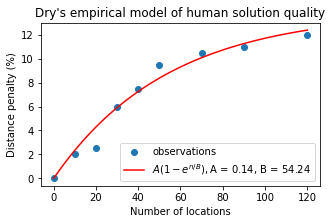

In [17]:
plt.figure(figsize=(5,3))
plt.scatter(n.flat, 100 * p.flatten(), label='observations')
n_fit = np.linspace(0,120)
p_fit = curve(n_fit, *params)
plt.plot(n_fit, 100 * p_fit, 'r-', label=r'$A(1 - e^{n/B}), $' + f'A = {params[0]:.2f}, B = {params[1]:.2f}' )

plt.xlabel('Number of locations')
plt.ylabel('Distance penalty (%)')
plt.title('Dry\'s empirical model of human solution quality')
plt.legend(loc='lower right')
plt.savefig('dry_model.png', dpi=250, bbox_inches='tight')

In [18]:
# Calculating the distance implied by all Vaximap routes. 
# The coordinates are stored in the dataset as latitude and longitude, so we need to convert into a metric 
# coordinate system (EPSG3857) and then can use distance matrices to work out the length of each closed route 
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)

def get_vaximap_route_length(latlong, routes):
    lat, lng = (latlong + UK_CENTER).T
    ll_m = transformer.transform(lng, lat)
    ll_m = np.vstack(ll_m).T
    dm = spatial.distance_matrix(ll_m, ll_m)
    dm[dm > MAX_PAIR_DIST] = 0 
    total = 0 
    for route in routes: 
        rt_length = sum([ dm[route[x], route[x+1]] for x in range(len(route) - 1) ])
        rt_length += dm[route[-1], route[0]]
        total += rt_length
    return total

# Calculate total length of routes for each request (ie, row of dataset). Then, we can apply the manual distance
# penalty which is a function of the total number of patients in the request 
dataset_nonrepeat = dataset_nonrepeat.assign(vaximap_distance=[ 
                        get_vaximap_route_length(row.latlong, row.clusters) 
                        for row in dataset_nonrepeat.loc[:,['latlong', 'clusters']].itertuples() ])
dataset_nonrepeat =  dataset_nonrepeat.assign(manual_distance= 
                        (dataset_nonrepeat['vaximap_distance'] 
                         * (1 + params[0] * (1 - np.exp(-dataset_nonrepeat['n_patients'] / params[1])))))

In [19]:
# Route lengths are in meters. Apply the detour index, convert into km, and apply average speed to convert into time 
dist_saving = DETOUR_INDEX * (dataset_nonrepeat['manual_distance'] - dataset_nonrepeat['vaximap_distance']).sum() / 1000
dist_saving_hrs = dist_saving / 50
print('travel savings %d km' % dist_saving)
print('travel savings %d hours' % dist_saving_hrs)
print('travel savings %d weeks (40hr week)' % (dist_saving_hrs / 40))
total_savings_hrs = dist_saving_hrs + planning_time_hrs
print('total savings %d hours' % total_savings_hrs)
print('total savings %d weeks (40hr week)' % (total_savings_hrs / 40))

travel savings 40374 km
travel savings 807 hours
travel savings 20 weeks (40hr week)
total savings 5307 hours
total savings 132 weeks (40hr week)


In [20]:
# Convert into cost savings 
pm_salary = 38e3 # practice manager
cn_salary = 32e3 # community nurse 
total_cost_savings = (pm_salary * planning_time_hrs / (40 * 48)) + (cn_salary * dist_saving_hrs / (40 * 48))
print('Total cost savings', total_cost_savings)

Total cost savings 102516.53953258522


## Summary plots 
A variety of plots showing high level summaries of dataset 

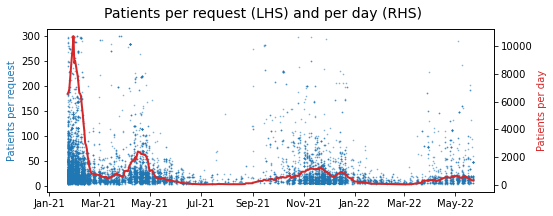

In [21]:
# sort the dataframe by date created
dataset_repeat['created'] = pd.to_datetime(dataset_repeat.created)
dataset_repeat = dataset_repeat.sort_values(by='created')

# define average patients per cluster
dataset_repeat['patients_per_cluster'] = (dataset_repeat['n_patients']/dataset_repeat['n_clusters'])

# get the raw data
y = dataset_repeat.n_patients
x = dataset_repeat.created

# bin the data by date
binned = dataset_repeat['n_patients'].groupby(dataset_repeat['created']).sum()
x_binned = binned.index
y_binned = binned.values

def movingaverage(interval, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

def add_titlebox(ax, text):
    ax.text(.67, .8, text,
        horizontalalignment='center',
         transform=ax.transAxes,
         bbox=dict(facecolor='white', alpha=0.2),
         fontsize=12.5)
    return ax

fig, ax1 = plt.subplots(1,1, figsize=(8, 3))
ax11= ax1.twinx()

# Headline figure
fig.suptitle('Patients per request (LHS) and per day (RHS)',
              fontsize=14)
sctr = ax1.scatter(x, y, color='tab:blue', alpha=0.5, s=0.4)
y_av = movingaverage(y_binned, 14)
ax11.plot(x_binned, y_av, "tab:red", linewidth=2)
ax1.set_yscale('linear')
ax1.set_ylabel('Patients per request', color='tab:blue')
#ax1.text(0.8, 0.8, r'A', fontsize=15,transform=ax.transAxes)
ax11.set_ylabel('Patients per day', color='tab:red')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
plt.savefig('timeseries.png', dpi=250, bbox_inches='tight')

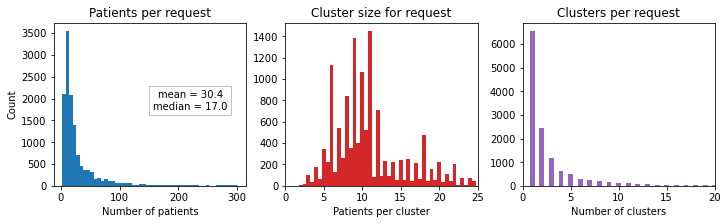

In [22]:
# Patients per route
fig, axes = plt.subplots(1, 3, figsize=(10, 3), constrained_layout=True)

ax1 = axes[0]
ax1.hist(dataset_repeat.n_patients, bins=50)
ax1.set_xlabel('Number of patients')
ax1.set_ylabel('Count')
ax1.set_title('Patients per request')
ax1.text(220, 1750, f'mean = {dataset_repeat.n_patients.mean():.1f}\n'
                    +f'median = {dataset_repeat.n_patients.median():.1f}',
        horizontalalignment='center',
        bbox=dict(facecolor='white', alpha=0.25))

ax2 = axes[1]
binwidth=0.5
ax2.hist(dataset_repeat.patients_per_cluster, bins=np.arange(min(dataset_repeat.patients_per_cluster), 
                                                      max(dataset_repeat.patients_per_cluster) + binwidth, binwidth),
         color='tab:red', align='left')
ax2.axis(xmin=0,xmax=25)
ax2.set_title('Cluster size for request')
ax2.set_xlabel('Patients per cluster')

# Clusters per route
ax3 = axes[2]
binwidth=0.5
ax3.hist(dataset_repeat.n_clusters, bins=np.arange(min(dataset_repeat.n_clusters), 
                                            max(dataset_repeat.n_clusters) + binwidth, binwidth),
                                            align='left', color='tab:purple')
ax3.axis(xmin=0,xmax=13.5)
ax3.set_title('Clusters per request')
ax3.set_xlabel('Number of clusters')
ax3.set_xlim(0,20)

plt.savefig('hists.png', dpi=250, bbox_inches='tight')

## Geographic analysis
Extract postcodes (to be plotted via another program not available here)

In [23]:
has_pc = [ bool(pc) for pc in dataset_repeat.postcodes ]
print(f'{len(has_pc)} rows, {sum(has_pc)} have postcodes')

12938 rows, 6594 have postcodes


In [24]:
pc_counts = Counter() 
[ pc_counts.update(pc) for pc in dataset_repeat.postcodes.tolist() ] 

df = pd.DataFrame(data={"postcodes" : pc_counts.keys(), "num" : pc_counts.values()})
df1 = df.groupby("postcodes").sum()
df1["name"] = df1.index.str[:2]
df1.to_csv("postcodes.csv", header=True)